# Tutorial: Symbolic Regression

Welcome to this tutorial on symbolic regression! Symbolic regression offers the unique advantage of creating inherently explainable models by uncovering mathematical expressions that describe data. Once a prominent technique, it has been overshadowed by more complex methods, making it an old and forgotten child of machine learning. However, recent advancements have rekindled interest in its capabilities.

Symbolic regression stands out for its ability to produce models that are both accurate and interpretable. By revealing the underlying mathematical relationships in data, it allows for greater insight and understanding, making it a valuable tool in various fields. In this tutorial you will use and compare the following methods to discover relationships between datapoints.

1. Non-symbolic regression methods:
    1. Decision Tree Regression
    2. Random Forest Regression
2. Symbolic regression methods:
    1. GPLearn: SR based on genetic programming by Trevor Stephens (2015)  (https://github.com/trevorstephens/gplearn)
    2. PySR: SR based on a multi-population evolutionary algoritm by Miles Cranmer (2023) (https://arxiv.org/abs/2305.01582)
    3. GFN-SR: Symbolic regression with generative flow networks by Li et al. (2023) (https://arxiv.org/abs/2312.00396)

The notebook introduces you to symbolic regression with some initial examples, followed by exercises and snippets of your own code.

## Section 0: Introduction

Before we start, we import all relevant packages below.

In [1]:
# RUN THIS CELL FIRST. Do not change.

from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.utils.random import check_random_state
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

### Data Generation

First, we create the data used for the three methods mentioned above. The code below creates a surfaceplot of all points (x1,x2) between -1 and 1 for two features x1 and x2, according to the equation y_truth = x1^2 - x1^2 + x2 - 1. In the methods below we will try to find an equation that best fits y_truth. 

Recall that in case of symbolic regression, the goal is to find an equation. In this example, the true equation is non-linear. To compare to other non-linear methods, we include Decision Tree (DT) Regression and Random Forest (RF) Regression. However, these methods will not produce an equation, but will simply train a DT or RF that best matches the given data.

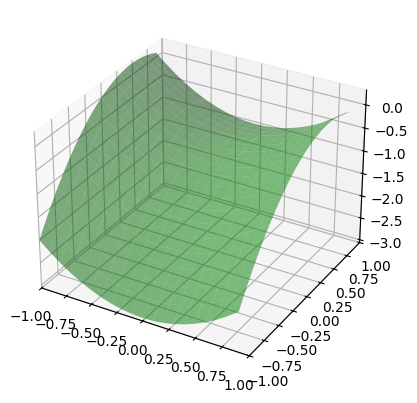

In [2]:
# RUN THIS CELL. Do not change.

# Generating data
x1 = np.arange(-1, 1, 1/10.)
x2 = np.arange(-1, 1, 1/10.)
x1, x2 = np.meshgrid(x1, x2)
y_truth = x1**2 - x2**2 + x2 - 1

# Creating surface plot of y_truth
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x1, x2, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()

## Section 1: Introduction to Non-Symbolic Regression Methods

In this section, we'll explore non-symbolic regression methods, which highlight the need for symbolic regression. Non-symbolic methods, like Decision Tree (DT) Regression and Random Forest (RF) Regression, are effective for prediction but have notable limitations. Note that non-symbolic regression methods will not produce an equation, but simply an output. 


### Create train- and testdatasets

We'll now create the actual train and test data. The train dataset will consist of a 100 samples. We use y = x1^2 - x1^2 + x2 - 1. Running the cell below shows you the first five samples of all 100 samples. 

In [3]:
# RUN THIS CELL. Do not change.

rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

train_df = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y': y_train})
print(train_df.head())

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

         x1        x2         y
0  0.097627  0.430379 -0.745316
1  0.205527  0.089766 -0.876050
2 -0.152690  0.291788 -0.770038
3 -0.124826  0.783546 -0.814817
4  0.927326 -0.233117 -0.427528


### Training the models

We train a Decision Tree Regression model and Random Forest Regression model. Tree Regression methods aim to find a tree that will travel through the branches to end up in a note with the value closest to the target value. For example, given sample a new samle (x1,x2) = (4.0, 2.0). The tree regressor may create decision rules such as `(x1 <= 5.0) and (x2 <= 3.0), then y = 3.5`. The decision rules created should produce output values that closely matches the y-column of our datadet.

In [4]:
# RUN THIS CELL. 

# Fit Decision Tree and Random Forest regression
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)

####
# (Optional for Question 6) YOUR CODE HERE
####

est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

RandomForestRegressor()

We visualize the output below.

<>:21: SyntaxWarning: invalid escape sequence '\/'
<>:21: SyntaxWarning: invalid escape sequence '\/'
/var/folders/9f/hchm_zr16lvg9fx_7pdqcws80000gn/T/ipykernel_94078/790698944.py:21: SyntaxWarning: invalid escape sequence '\/'
  score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=8)


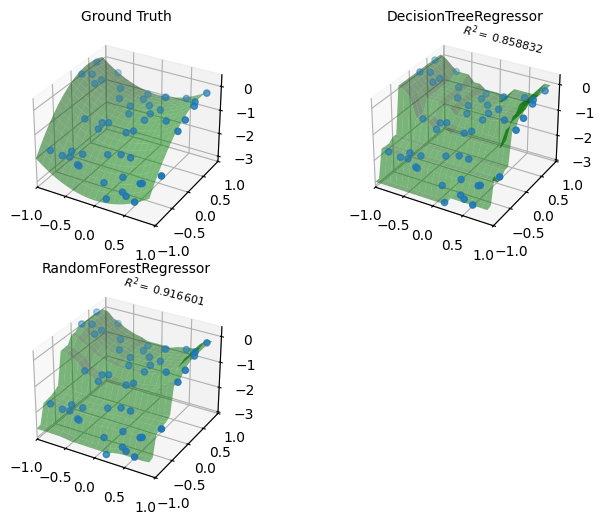

In [6]:
# RUN THIS CELL. Do not change.

y_tree = est_tree.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(8, 6))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                    #    (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x1, x2, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=8)
    plt.title(title, fontsize = 10)
plt.show()

### Question 1 (1pts total)
#### Q1a - (0.5pts): Describe what results you see in the figure.

#### Q1b - (0.5pts): Can you think of at least two possible limitations to using non-symbolic regression methods for symbolic regression?

## Section 2: Introduction to Symbolic Regression Methods (GPLearn)

Symbolic regression has traditionally relied on Genetic Programming (GP) to discover mathematical equations that describe data. In GP, equations are represented as tree-like structures, where nodes are mathematical operators and leaves are variables or constants. New equations are generated through evolutionary processes like mutation and crossover of these trees, mimicking natural selection. This approach allows for the exploration of a vast space of possible equations.

In this section, we will introduce GPLearn, a Python library that utilizes genetic programming for symbolic regression. We will explore how GPLearn works and why symbolic regression is valuable for creating interpretable models that reveal the underlying mathematical relationships in data.

### 2-1: GPLearn

We'll begin by training a model using GPLearn, a genetic programming library for symbolic regression. The resulting equations will be composed of basic arithmetic operators: addition, subtraction, division, and multiplication.

For example:

- `add(x1,3.0)` represents x1+3.

- `sub(x2,add(x1,3.0))` represents x2-(x1+3).

This introduction to GPLearn will include a comparison with Decision Tree (DT) Regression and Random Forest (RF) Regression, highlighting the unique advantages and interpretability of symbolic regression.

In [7]:
# RUN THIS CELL. Do not change.

# Fit SymbolicRegressor
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

# Generate equation
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764     35.95s
   1     9.97          1.70233        5         0.320202         0.624787     21.60s
   2     7.72          1.94456       11         0.239537         0.533148     19.36s
   3     5.41         0.990157        7         0.235676         0.719906     17.85s
   4     4.66         0.894443       11         0.103946         0.103946     17.00s
   5     5.41         0.940242       11         0.060802         0.060802     15.92s
   6     6.78          1.09536       11      0.000781474      0.000781474     14.53s
sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


We visualize the output and compare to the non-symbolic regression methods.

<>:19: SyntaxWarning: invalid escape sequence '\/'
<>:19: SyntaxWarning: invalid escape sequence '\/'
/var/folders/9f/hchm_zr16lvg9fx_7pdqcws80000gn/T/ipykernel_94078/3905327180.py:19: SyntaxWarning: invalid escape sequence '\/'
  score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=8)


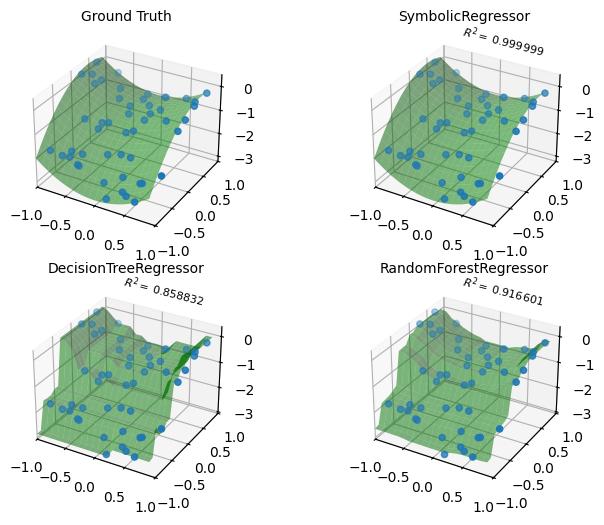

In [8]:
# RUN THIS CELL. Do not change.

y_gp = est_gp.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)
score_gp = est_gp.score(X_test, y_test)

fig = plt.figure(figsize=(8, 6))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x1, x2, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=8)
    plt.title(title, fontsize = 10)
plt.show()

#### Question 2 (1pts): Describe what results you see in the figure. What are your thoughts so far on using GPLearn for (symbolic) regression?

## Section 3: Comparing Non-Symbolic Regression vs. Symbolic Regression

In this section, we will compare non-symbolic regression methods with three established symbolic regression methods. You will explore how to perform each approach and understand the benefits of symbolic regression in providing interpretable models.

The methods we will compare are:

1. Decision Tree Regression (Non-Symbolic)
2. Random Forest Regression (Non-Symbolic)
3. GPLearn (Symbolic)
4. PySR (Symbolic)
5. GFN-SR (Symbolic)

### 3-1: PySR

We've established that the symbolic regression method GPLearn performs comparably to traditional regression methods (DT and RF). Now, let's explore and compare the remaining two prominent symbolic regression methods (PySr and GFN-SR)

In [9]:
# RUN THIS CELL. Do not change.

sys.path.insert(0, os.path.join(os.getcwd(), 'PySR'))
from pysr import PySRRegressor

X = rng.uniform(-1, 1, 100).reshape(50, 2)
y = X[:, 0]**2 - X[:, 1]**2 + X[:, 1] - 1

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

model.fit(X, y)

print(model)
print(model.get_best())

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/Users/adialumadjeng/Projects/IE-in-AI-SR/ie-in-ai-SR/PySR/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                        -0.28737655   
	1         6.517324e-01                                    inv(-0.9722635)   
	2         1.173444e+00                                    -1.0623512 + x1   
	3         5.811268e-04                        (x1 * 1.023314) + -1.063143   
	4         6.474519e-01                        (cos(x0) * -1.2888113) + x1   
	5         1.890811e-01                      (x0 * x0) + (-1.3955851 + x1)   
	6         6.862176e-03            x1 + (cos(1.2634565 * x0) * -1.4043528)   
	7         1.248710e+00             (-2.222682 * cos(x0)) + (cos(x1) + x1)   
	8         1.487991e+00  (cos(x1 * -1.4887787) + (cos(x0) * -1.9921768)...   
	9         1.545694e+00  x1 + ((-1.98271 + cos(x1 * 1.5322164)) + (x0 *...   
	10        6.737755e-04  x1 + ((-1.98271 + cos((x1 + 0.00049597875) * 1...   
	11        4.849703e-07  x1 + ((-2.

### 3-2: GFN-SR

training started with device cpu


14.905:   1%|          | 1/100 [00:00<00:23,  4.23it/s]

action_fns:  [None, 0, 1, <built-in method square of type object at 0x2c2df3810>, <built-in method sqrt of type object at 0x2c2df3810>, <built-in method log of type object at 0x2c2df3810>, <built-in method cos of type object at 0x2c2df3810>, <built-in method sin of type object at 0x2c2df3810>, <built-in method exp of type object at 0x2c2df3810>, <built-in method mul of type object at 0x2c2df3810>, <built-in method add of type object at 0x2c2df3810>, <built-in method div of type object at 0x2c2df3810>, <built-in method sub of type object at 0x2c2df3810>]
action_arities:  tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])
action_names : ['c', 'x1', 'x2', 'square', 'sqrt', 'log', 'cos', 'sin', 'exp', '*', '+', '/', '-']

new best reward (vanilla): 0.3896152377128601
mse (pre/post optimized): 53.37709426879883/55.80449295043945
best encoding: tensor([11,  9,  9,  1,  1,  1,  0])
((x1) * (x1)) / ((x1) * (0.35))
expr: 2.85714285714286*x1
action_fns:  [None, 0, 1, <built-in method square of type

4.427:  59%|█████▉    | 59/100 [00:02<00:01, 24.31it/s] 

action_fns:  [None, 0, 1, <built-in method square of type object at 0x2c2df3810>, <built-in method sqrt of type object at 0x2c2df3810>, <built-in method log of type object at 0x2c2df3810>, <built-in method cos of type object at 0x2c2df3810>, <built-in method sin of type object at 0x2c2df3810>, <built-in method exp of type object at 0x2c2df3810>, <built-in method mul of type object at 0x2c2df3810>, <built-in method add of type object at 0x2c2df3810>, <built-in method div of type object at 0x2c2df3810>, <built-in method sub of type object at 0x2c2df3810>]
action_arities:  tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])
action_names : ['c', 'x1', 'x2', 'square', 'sqrt', 'log', 'cos', 'sin', 'exp', '*', '+', '/', '-']

new best reward (vanilla): 0.820941686630249
mse (pre/post optimized): 3.0413200855255127/3.0413200855255127
best encoding: tensor([ 9, 10, 12,  1,  2,  1,  2])
((x1) + (x2)) * ((x1) - (x2))
expr: (x1 - x2)*(x1 + x2)


0.137: 100%|██████████| 100/100 [00:03<00:00, 25.39it/s]


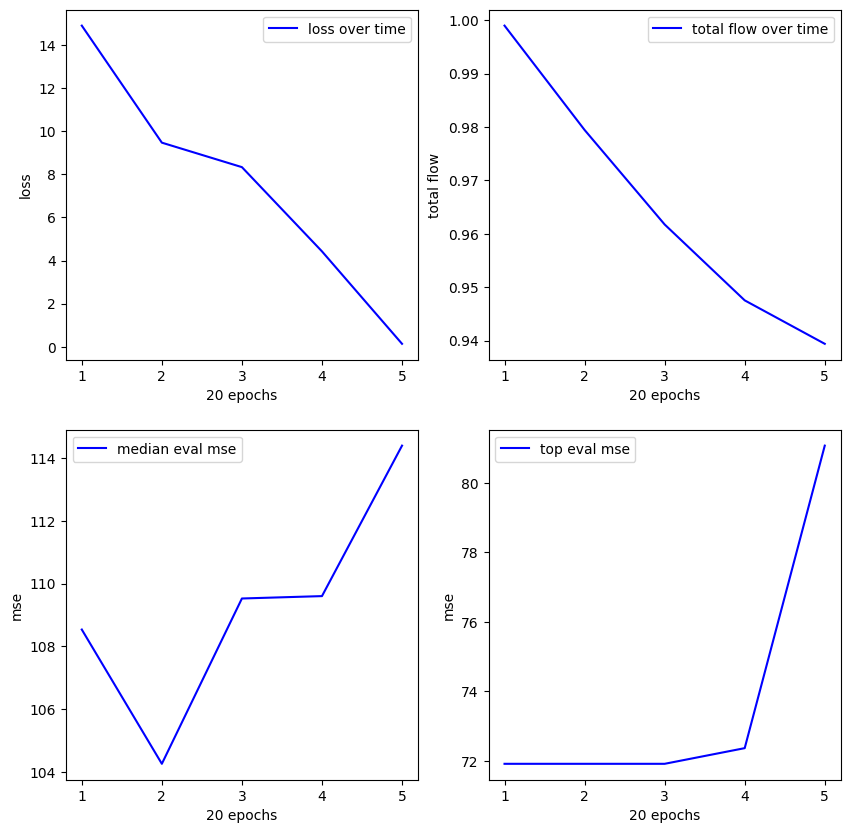

In [10]:
# RUN THIS CELL. Do not change.

sys.path.insert(0, os.path.join(os.getcwd(), 'gfn-sr'))
from train import train_gfn_sr

# Define the arguments (simulating command-line arguments)
batch_size = 64
num_epochs = 100

# Call the training function
model, env, errs, avg_mses, top_mses = train_gfn_sr(batch_size, num_epochs, show_plot=True, use_gpu=True)

### Question 3 (total 2pts)
#### Q3a - (0.5pts) For the complete output of PySR, check the hall_of_fame-csv-file. What is meant by the complexity of PySR?

#### Q3b - (1.5pts): What are the expressions generated for the equation y = x1^2 - x1^2 + x2 - 1 by all three symbolic regression methods (e.g. GPLearn, PySR, GFN-SR)? For PySR, choose an equation of appropriate complexity to compare. Which method do you prefer now and why?

### Question 4 (total 2pts)
#### Q4a - (0.5pts): Compare the generated decision rules of the non-symbolic regressors against each of the symbolic expressions. Which one do you prefer and why? Show how you compare the methods.

#### Q4b (1.5pts): Create another example equation that results in a less interpretable solution for the non-symbolic regression methods in comparison to the symbolic regression. Compare these decision rules that you generated with DT and RF to the symbolic regressors in terms of complexity, compactness and R-squared. Report all your findings.

In [ ]:
####
# (Question 4) YOUR CODE
####

## Section 4: Comparing the Symbolic Regression Methods

In this section, we will explore and compare GPLearn, PySR, and GFN-SR using more complex equations and additional features in our dataset. We will also check the robustness of these methods, and finally, apply them to real-world datasets. 

### 4-1: Increasing the complexity

We increase the difficulty of the equation by:
1. Increasing the length of the expression/depth of the expression tree
2. Increase the number of features


#### Question 5 (3pts): For all six functions below, run the three symbolic regression methods. Report its performance in terms of the MSE and R2-score. Describe what you observe and conclude.

You can do this by creating a train set of a 100 samples, and a test set of a 100 samples. When needed, you may choose the parameters yourself accordingly.

Note: to run GFN-SR, you have to change the function in train.py of ./gfn-sr

In [ ]:
# RUN THIS CELL. Do not change.

X = rng.uniform(-1, 1, 100).reshape(50, 2)

# Simple Polynomial
y1 = X[:, 0]**2 + X[:, 1]**2

# Polynomial with interaction terms
y2 = X[:, 0]**2 + X[:, 1]**2 + X[:,0]*X[:,1]

# Polynomial with higher degree terms
y3 = X[:, 0]**3 + X[:, 1]**3 + X[:,0]*X[:,1]

# Trigonometric Functions
y4 = np.sin(X[:,0])+np.cos(X[:,1])

# Mixed functions
y5 = np.sin(X[:,0]) + X[:,1]**2 + np.exp(X[:,1])


In [ ]:
# Create train and test samples for y1 up to y5.

########

# GPLearn
# Training samples
y1_train = y1
y2_train = y2
y3_train = y3
y4_train = y4
y5_train = y5
X_train = X

train_df1 = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y1': y1_train})
train_df2 = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y2': y2_train})
train_df3 = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y3': y3_train})
train_df4 = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y4': y4_train})
train_df5 = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y5': y5_train})

# # Testing samples
X_test = X
########

In [ ]:
# Run GPLearn
from sklearn.metrics import r2_score, mean_squared_error

########

# Define parameters for SymbolicRegressor
params = {
    'population_size': 5000,
    'generations': 20,
    'stopping_criteria': 0.01,
    'p_crossover': 0.7,
    'p_subtree_mutation': 0.1,
    'p_hoist_mutation': 0.05,
    'p_point_mutation': 0.1,
    'max_samples': 0.9,
    'verbose': 1,
    'parsimony_coefficient': 0.01,
    'random_state': 0,
}

# Loop through equations
for i, y_train in enumerate([y1_train, y2_train, y3_train, y4_train, y5_train], start=1):
    print(f'\n Equation {i}:')
    # Create and fit SymbolicRegressor
    est_gp = SymbolicRegressor(**params)
    est_gp.fit(X_train, y_train)
    
    # Print the generated equation
    print('Generated Equation:')
    print(est_gp._program)
    
    # Generate predictions and calculate scores
    y_gp = est_gp.predict(X_train)
    print('R-squared: ', r2_score(y_train, y_gp))
    print('MSE: ', mean_squared_error(y_train, y_gp))

#######

In [ ]:
# Run PySR
sys.path.insert(0, os.path.join(os.getcwd(), 'PySR'))
from pysr import PySRRegressor

def positive_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

#######

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)


# List of y-values to iterate over
equations = [y1, y2, y3, y4, y5]

# Loop over each equation
for i, equation in enumerate(equations, start=1):
    print(f'\n Equation {i}:')
    model.fit(X, equation)
    y_pysr = model.predict(X)
    print(model.get_best())
    print('MSE:', mse_loss(equation, y_pysr))
    print('R-Squared:', positive_r2(equation, y_pysr))

#######

In [ ]:
# Run GFN-SR

sys.path.insert(0, os.path.join(os.getcwd(), 'gfn-sr'))
from train import train_gfn_sr
import torch

X = torch.empty(100, 2).uniform_(0, 1) * 5

#########
# Define the arguments (simulating command-line arguments)
batch_size = 64
num_epochs = 100

# Call the training function
model, env, errs, avg_mses, top_mses = train_gfn_sr(batch_size, num_epochs, show_plot=True, use_gpu=True)
#########

#### [OPTIONAL] Question 6 (0.5pts): Increase the number of features by one and compare the performances of the three methods based on your own equation involving three features.

### 4-2: Sensitivity to noise

Now you'll compare the methods to each other in terms of robustness. This means we add noise to the dataset and check how it performs.

#### [OPTIONAL] Question 7 (0.5pts): Add a noise term to your data set. This noise should be normally distributed between with a mean of 0 and standard deviation of 0.02. Considering performance (you may choose a metric yourself) and runtime, which method is most robust?


In [ ]:
########

X = rng.uniform(-1, 1, 100).reshape(50, 2)

# Generate noise with mean 0 and std dev 0.2
mean = 0
std_dev = 0.2
noise = rng.normal(loc=mean, scale=std_dev, size=X.shape)

# Add noise to X
X_noisy = X + noise

#######

### 4-3: Application to real-world benchmark dataset: AI Feynman

In this section, we delve into symbolic regression using equations from the AI Feynman database—a well-established collection of 100 physics-inspired equations curated by Udrescu & Tegmark (2019). These equations serve as a rigorous benchmark for evaluating the capabilities of symbolic regression methods.

Our goal is to assess how effectively GPLearn, PySR, and GFN-SR can uncover and represent these complex relationships. By applying these methods to the AI Feynman equations, we aim to gain insights into their performance in discovering fundamental laws and relationships, highlighting their strengths and areas for further improvement in practical applications.

### [OPTIONAL] Question 8 (2pts): Go to https://arxiv.org/abs/1905.11481 and find equations I.12.2, I.48.20, I.13.4, I.27.6, I.18.12 and I.29.16. What can you say about the structure of these functions? Then, Use GPLearn, PySR and GFN-SR on these equations. You may use a dataset of a 50 samples with values between 1 and 10 (without noise). Based on your findings in the previous question, which method do you think works best? Is there one method overall, or do you think one method works best for certain equations?

